In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from matplotlib.collections import LineCollection
from sklearn.metrics import RocCurveDisplay
from pycaret.anomaly import *
from sklearn.preprocessing import MinMaxScaler
# from pycaret.classification import *

In [2]:
data = pd.read_csv('raw_set.csv')
# attack = data[['time', 'attack']].copy()
# data = data.drop(['attack'],axis = 1)
col = [col for col in data.columns]
print(col)
print(data.shape)
time = data['time'].unique().shape[0]
print(time)
ics_entropy = np.zeros((time,data.shape[1]))
attack_entropy = np.zeros((time,))

['time', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.len', 'ip.id', 'ip.flags', 'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.hdr_len', 'tcp.flags', 'tcp.window_size', 'tcp.time_delta', 'tcp.time_relative', 'attack']
(626372, 20)
28850


In [3]:
def calc_entropy(value):
    uvalue,counts = np.unique(value, return_counts=True)
    if value.shape[0] > 1:
        return entropy(counts)
    else :
        return -1

def get_entropy(column,i,df):
    temp = df.loc[df['time'] == i]
    return calc_entropy(temp[column])

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [5]:
# for i in range(time):
#     result = [get_entropy(col[j],i,data) for j in range(1,len(col))]
#     if -1 not in result:
#         ics_entropy[i,1:] = result
        
# ics_entropy = ics_entropy[~np.any(ics_entropy == -1, axis=1)]
# ics_entropy = ics_entropy[~np.all(ics_entropy == 0, axis=1)]
# attack_entropy = ics_entropy[:,-1]
# print(ics_entropy.shape)
        
# ics_to_file = pd.DataFrame(ics_entropy)
# ics_to_file.columns = col
# ics_to_file.to_csv('ics_entropy.csv', index=False)
# attack_to_file = pd.DataFrame(attack_entropy)
# attack_to_file.columns = ['attack']
# attack_to_file.to_csv('ics_attack.csv', index=False)

ics_entropy = pd.read_csv('ics_entropy.csv')
ics_entropy = ics_entropy.drop(['ip.flags'],axis=1)
col = ics_entropy.columns
ics_entropy = ics_entropy.to_numpy()
attack_entropy = pd.read_csv('ics_attack.csv').to_numpy()

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
ics_entropy = scaler.fit_transform(ics_entropy)    
attack_time = np.asarray(np.where(attack_entropy > 0))[0]
print(attack_time)         
            

[13748 13946 13977 15827 15828 15833 15924 16036 16057 16094 16184 18051
 18052 18053 18054 18055 18056 18057 18058 18059 18060 18061 18062 18063
 18064 18065 18066 18067 18068 18069 18070 18071 18072 18073 18074 18075
 18076 18077 18078 18079 18080 18081 18082 18083 18084 18085 18086 18087
 18088 18089 18090 18091 18092 18093 18094 18095 18096 18097 18098 18099
 18100 18101 18102 18103 18104 18105 18106 18107 18109 18110 18111 18113
 18114 18115 18116 18117 18118 18119 18120 18121 18122 18123 18124 18125
 18126 18127 18128 18129 18130 18131 18132 18133 18134 18135 18136 18137
 18138 18139 18140 18141 18142 18143 18144 18145 18146 18147 18148 18149
 18150 18151 18152 18153 18154 18155 18156 18157 18158 18159 18160 18161
 18162 18163 18164 18165 18166 18167 18168 18169 18170 18171 18172 18173
 18174 18175 18176 18177 18178 18179 18180 18181 18182 18183 18184 18185
 18186 18187 18188 18189 18190 18191 18192 18193 18194 18195 18196 18197
 18198 18199 18200 18201 18202 18203 18204 18205 18

In [7]:
smooth_ics = ics_entropy.copy()  
smooth_ics = smooth_ics[4500:,:]
for i in range(smooth_ics.shape[1]):
    smooth_ics[:,i] = smooth(smooth_ics[:,i],500)
    
smooth_ics = smooth_ics[500:-500,:]
    
for j in range(len(smooth_ics[:,-1])):
    if smooth_ics[j,-1] > 0:
        smooth_ics[j,-1] = 1


print(np.unique(smooth_ics[:,-1]))

[0. 1.]


In [8]:
smooth_entropy = smooth_ics[:,-1]
smooth_time = np.asarray(np.where(smooth_entropy > 0))[0]

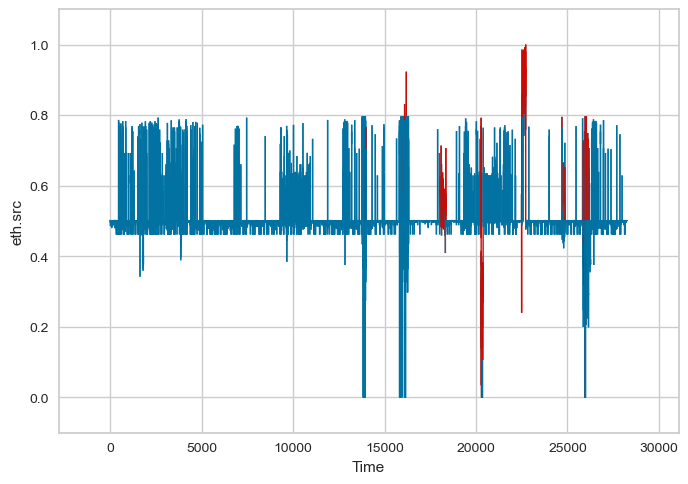

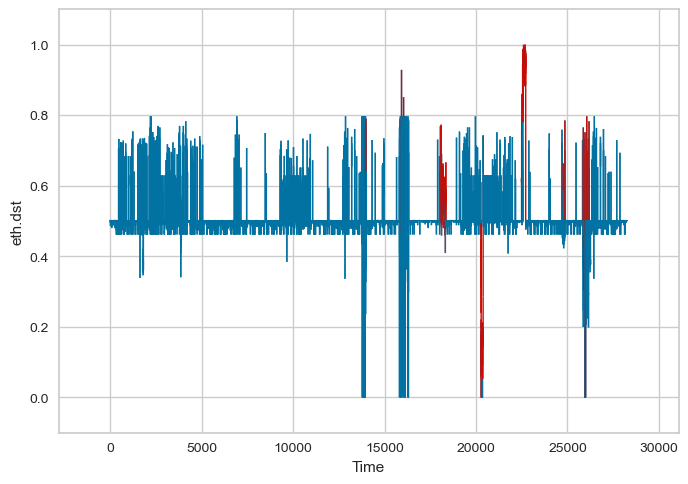

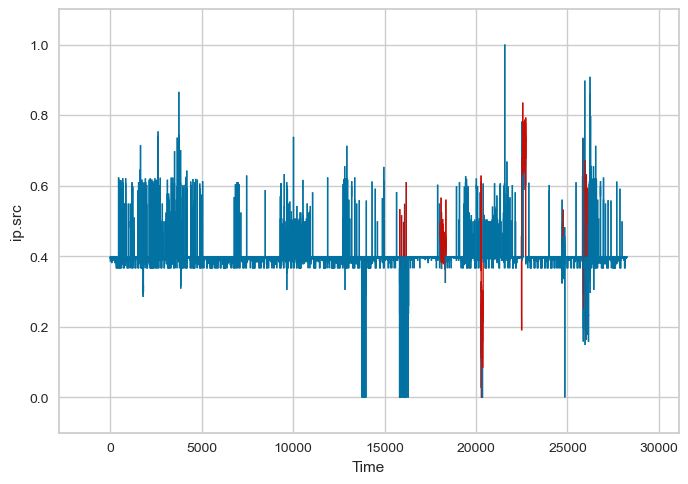

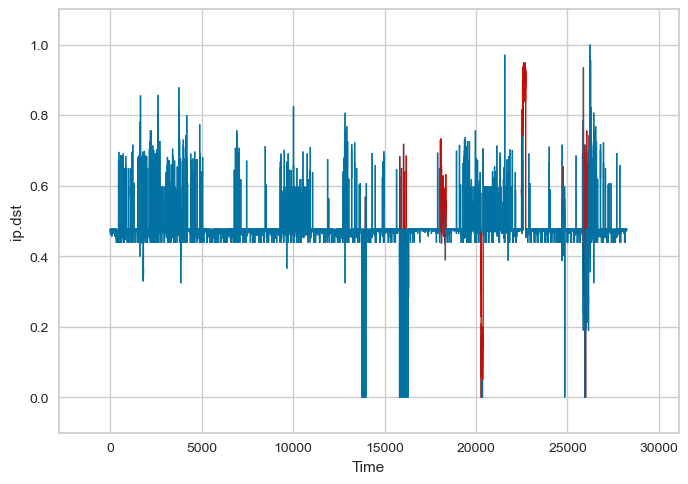

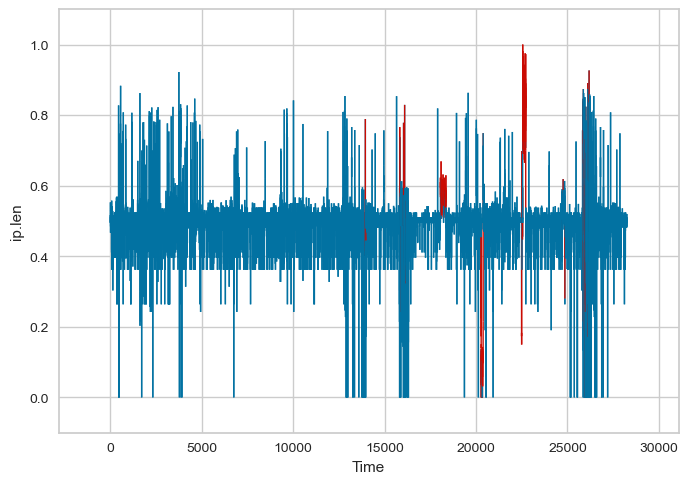

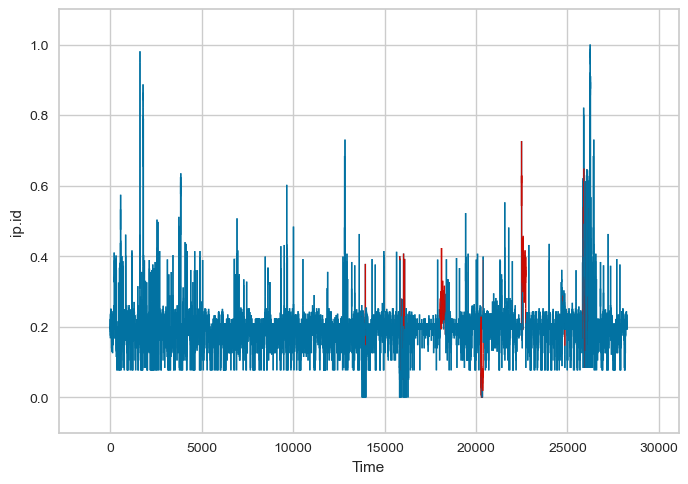

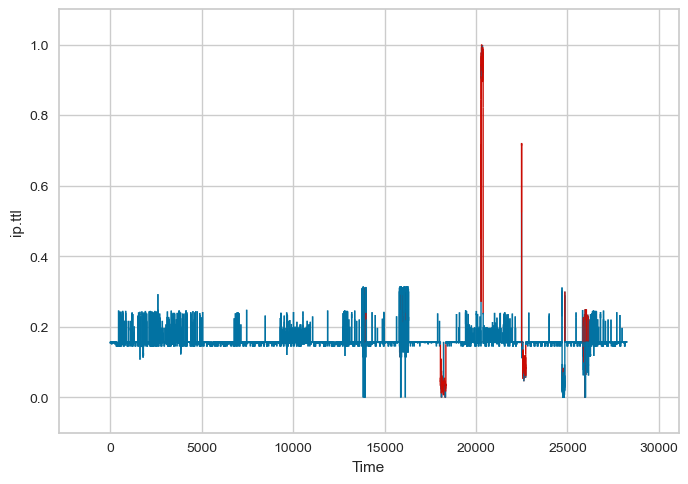

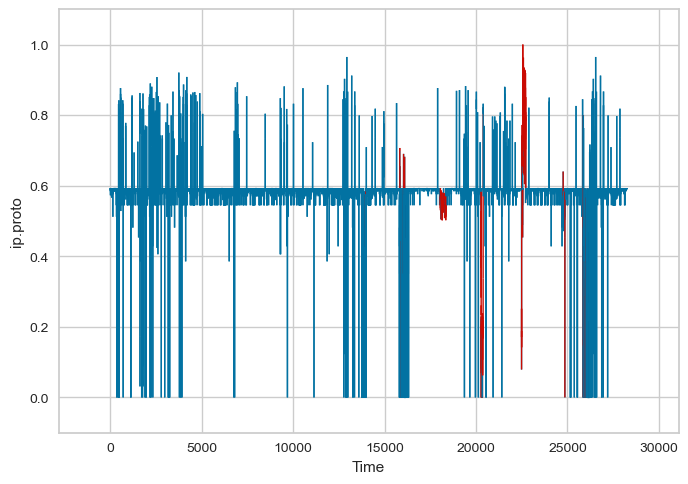

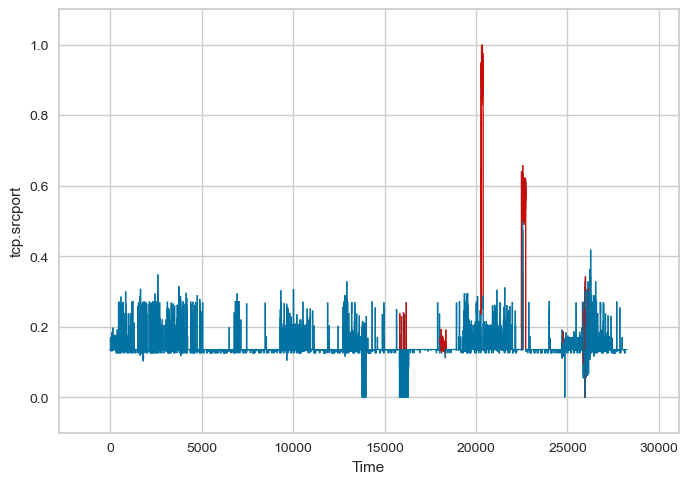

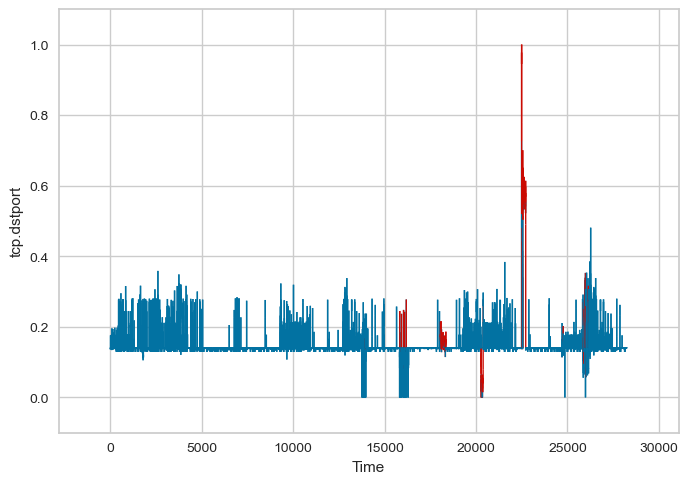

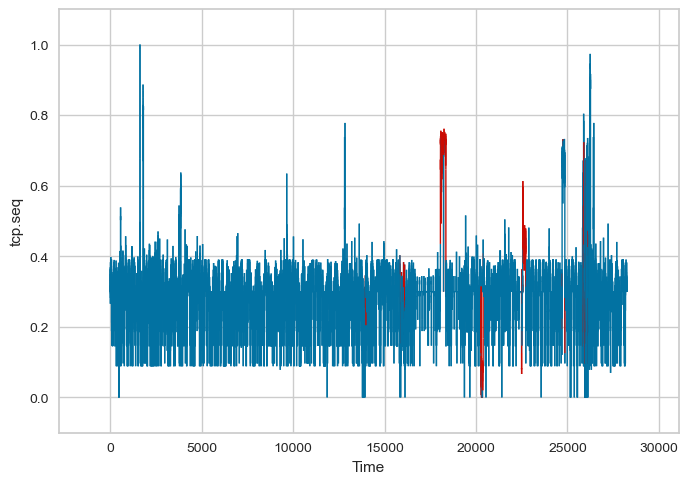

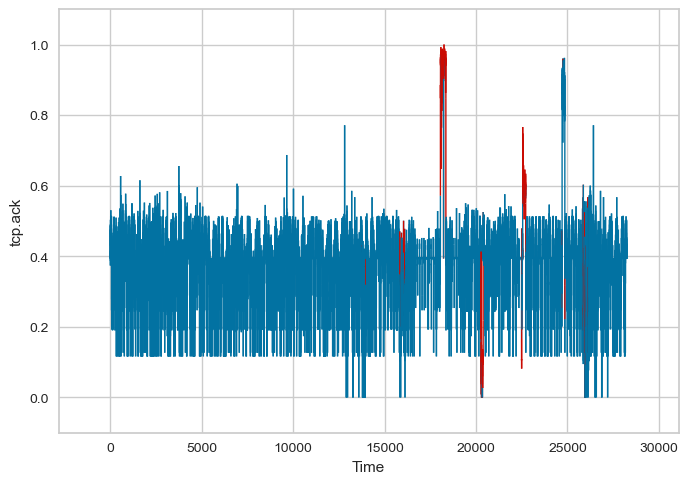

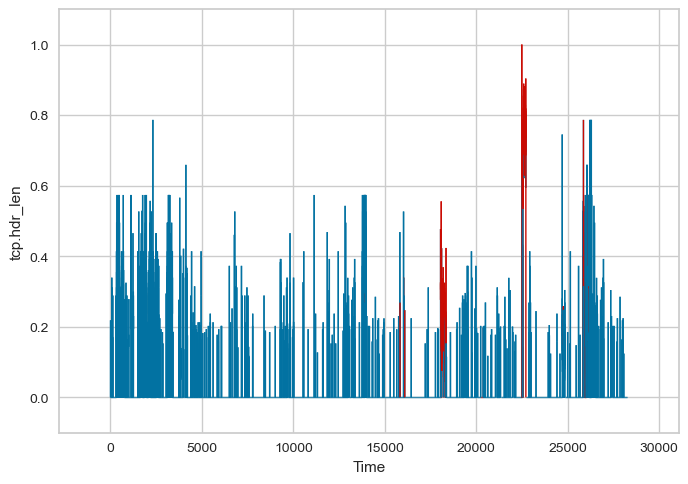

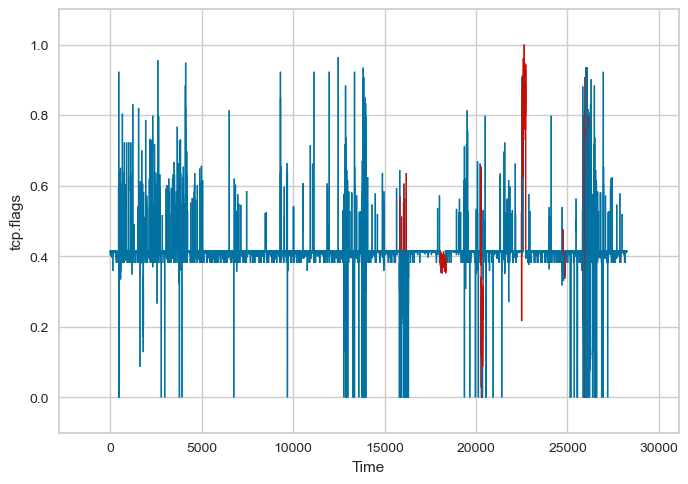

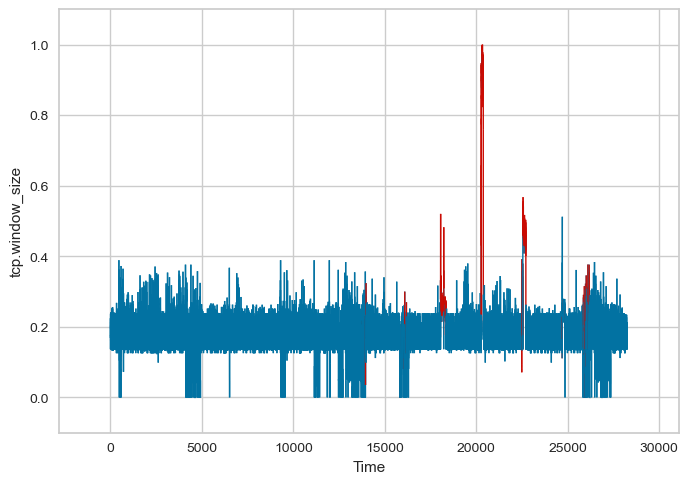

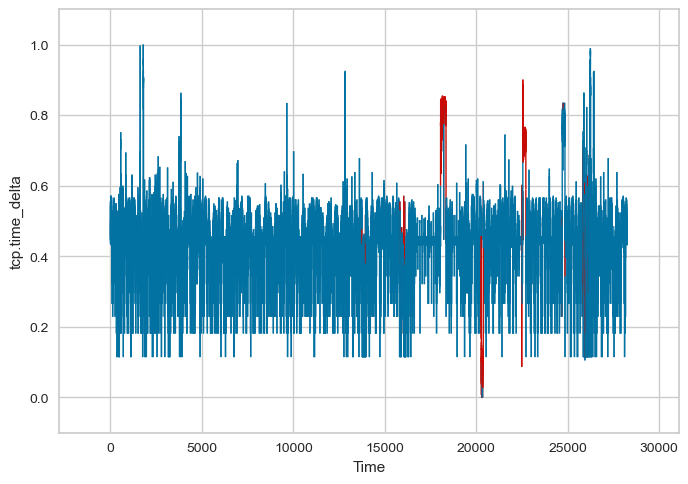

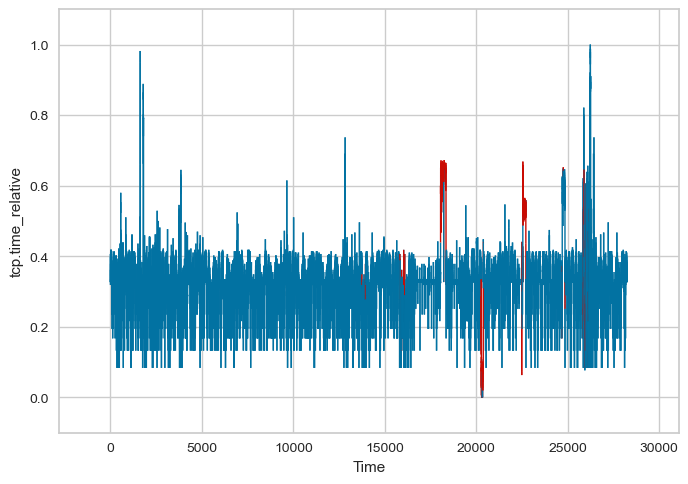

In [9]:
for i in range(1,ics_entropy.shape[1]-1):
    x = range(ics_entropy.shape[0])
    y = ics_entropy[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,attack_time) ))

    lc = LineCollection(segments, colors=colors, linewidths= 1)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

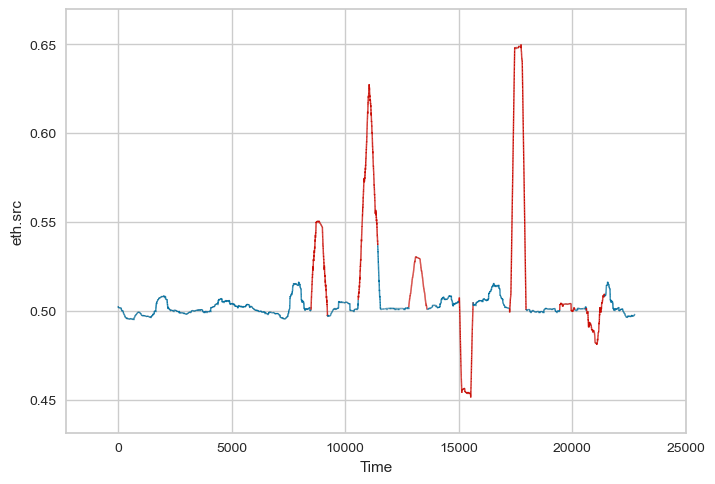

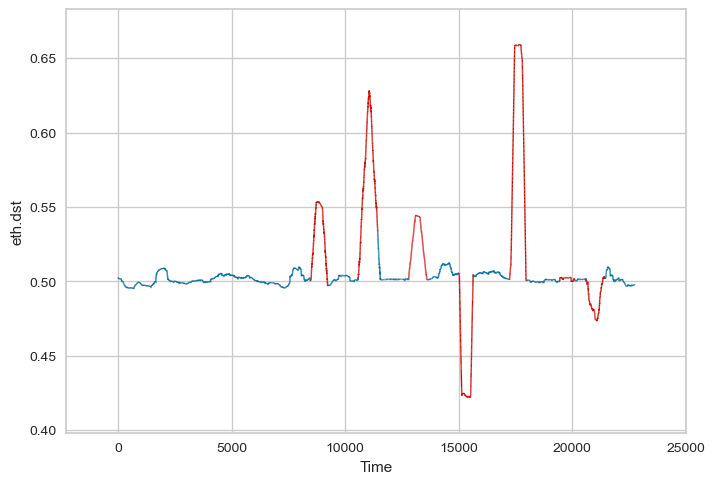

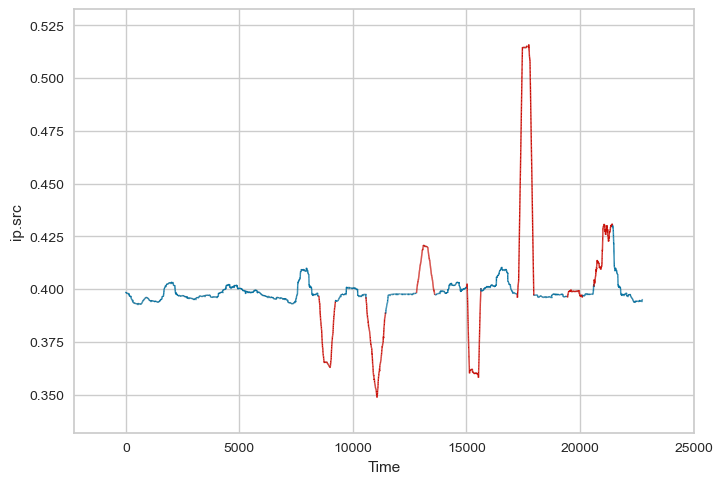

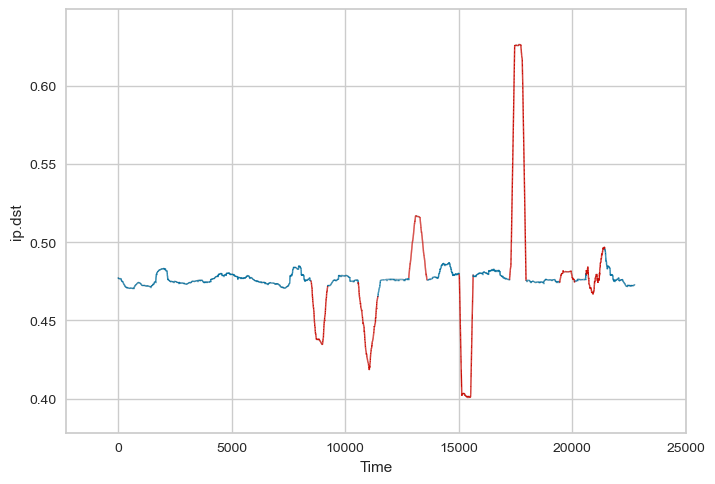

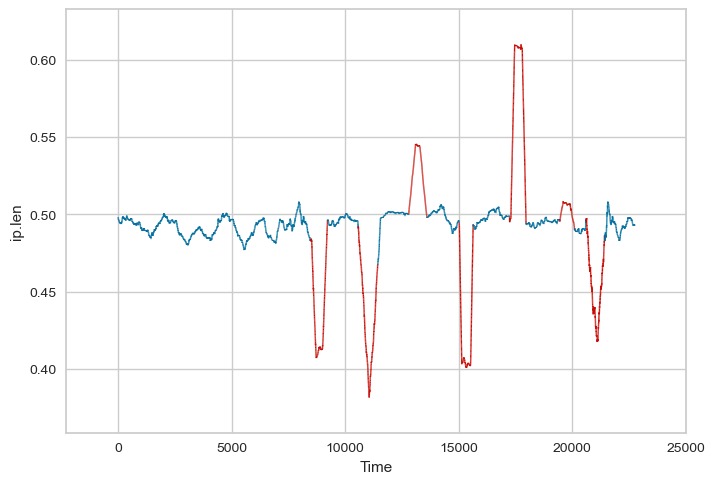

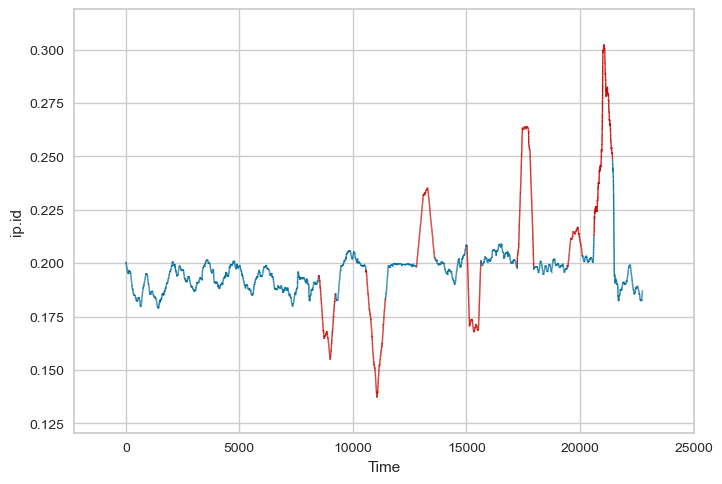

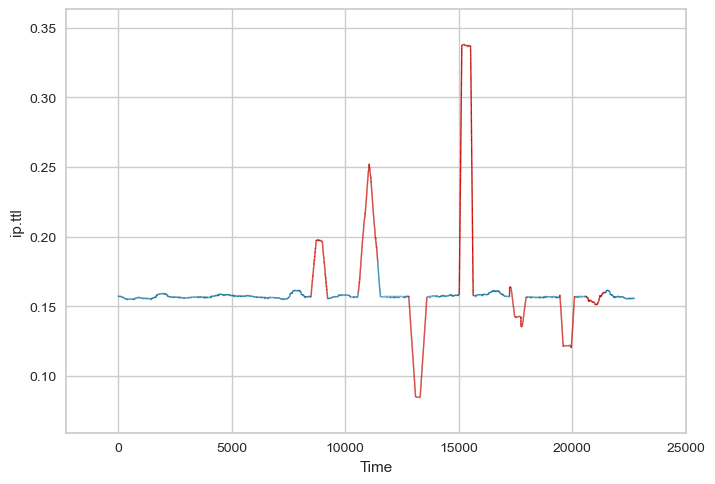

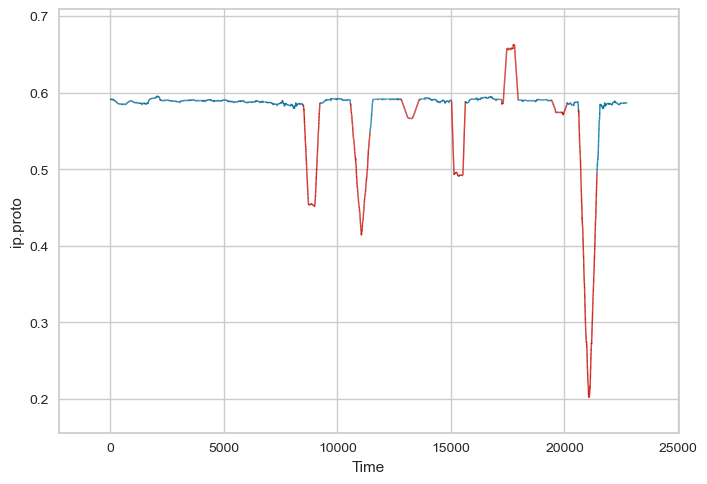

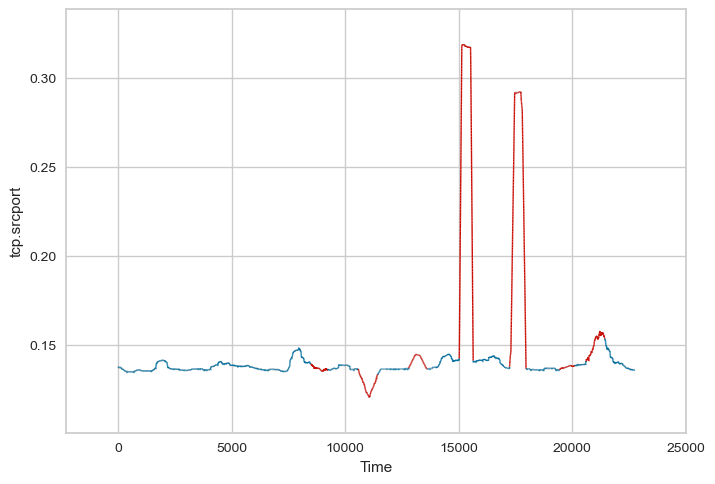

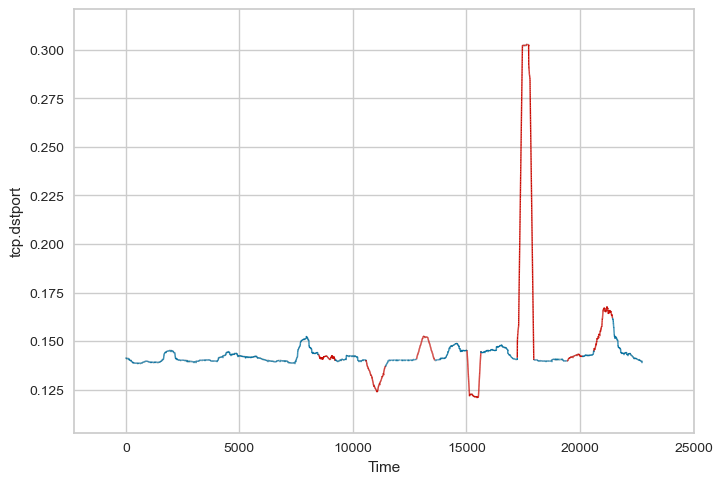

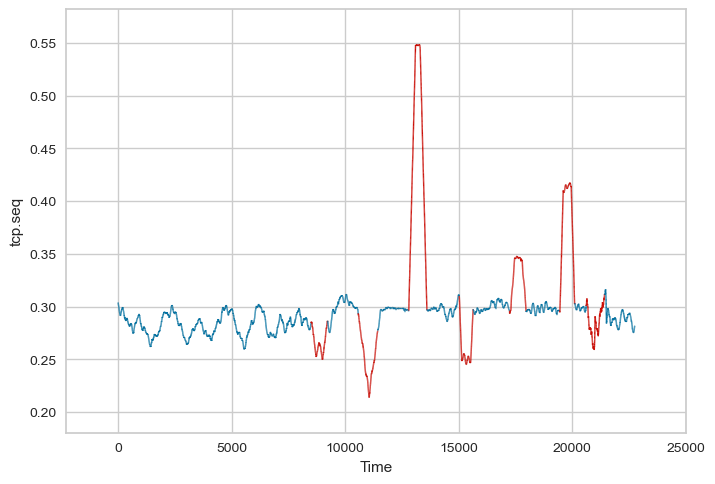

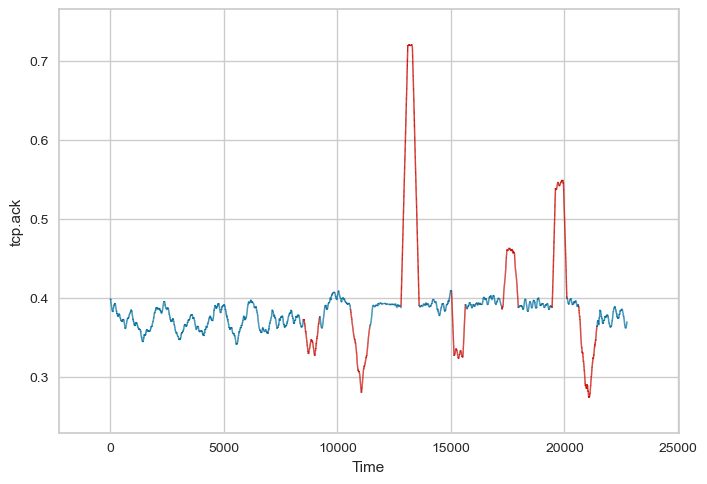

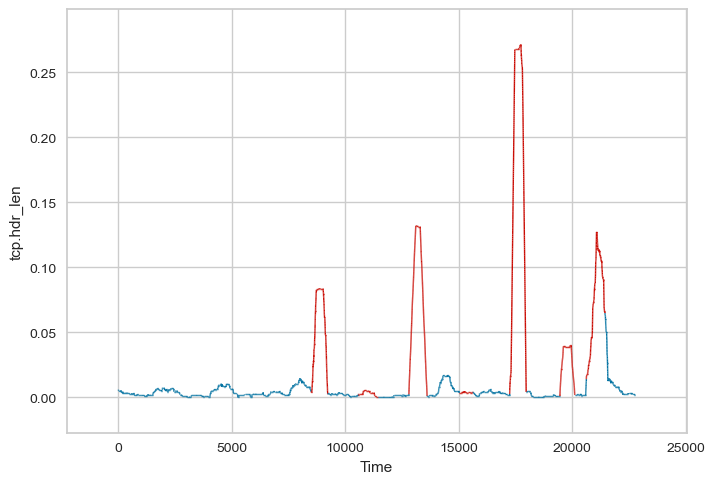

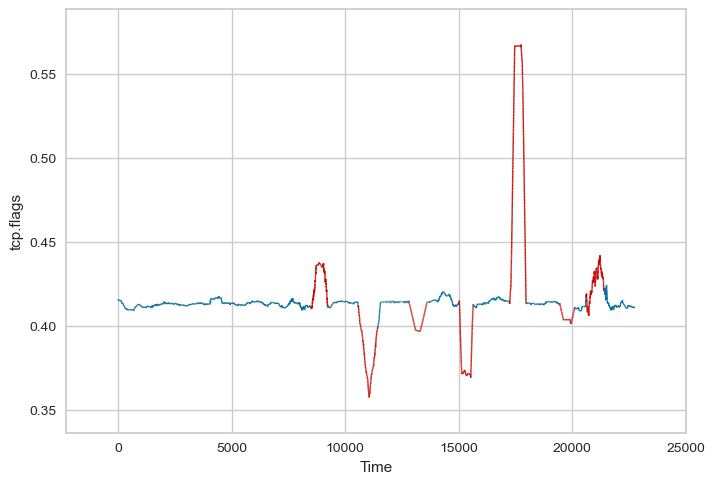

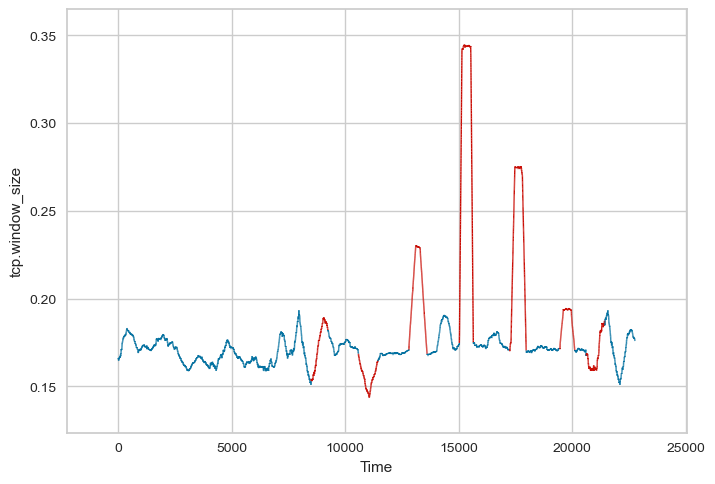

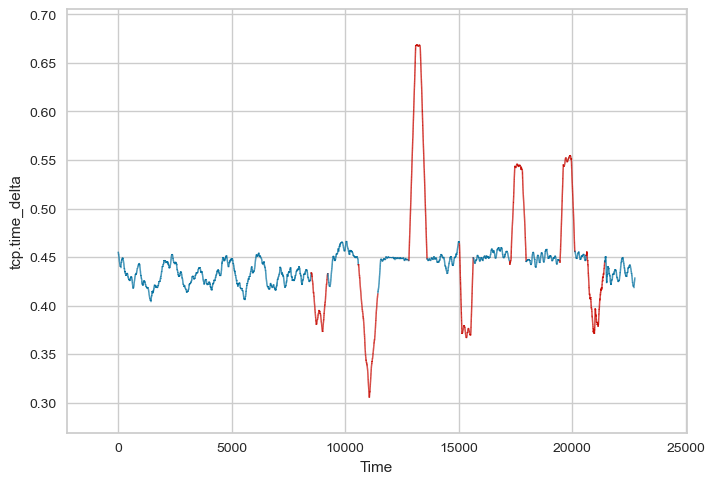

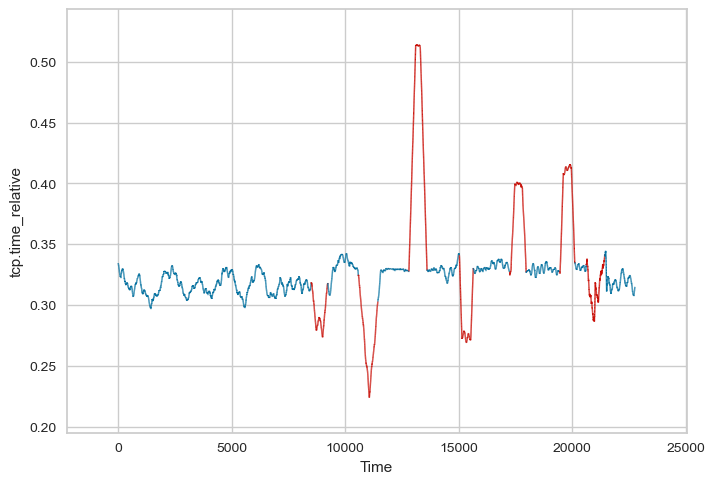

In [10]:
for i in range(1,len(col)-1):
    x = range(smooth_ics.shape[0])
    y = smooth_ics[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,smooth_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [11]:
# X = pd.DataFrame(smooth_ics[:,1:])
X = pd.DataFrame(smooth_ics[:,1:-1])
X.columns = col[1:-1]
# X.columns = col[1:]
setup(X,session_id=123)
# setup(X,target='attack',fix_imbalance = True,feature_selection=True)

,Description,Value
0,session_id,123
1,Original Data,"(22754, 17)"
2,Missing Values,False
3,Numeric Features,17
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(22754, 17)"
9,CPU Jobs,-1


({'abod': <pycaret.containers.models.anomaly.ABODAnomalyContainer at 0x7ff73b7a0df0>,
  'cluster': <pycaret.containers.models.anomaly.CBLOFAnomalyContainer at 0x7ff73bd3cb50>,
  'cof': <pycaret.containers.models.anomaly.COFAnomalyContainer at 0x7ff73b7a4e50>,
  'iforest': <pycaret.containers.models.anomaly.IForestAnomalyContainer at 0x7ff73b781940>,
  'histogram': <pycaret.containers.models.anomaly.HBOSAnomalyContainer at 0x7ff73b781a90>,
  'knn': <pycaret.containers.models.anomaly.KNNAnomalyContainer at 0x7ff73b7b0340>,
  'lof': <pycaret.containers.models.anomaly.LOFAnomalyContainer at 0x7ff7377a1130>,
  'svm': <pycaret.containers.models.anomaly.OCSVMAnomalyContainer at 0x7ff7377a11c0>,
  'pca': <pycaret.containers.models.anomaly.PCAAnomalyContainer at 0x7ff7377a1340>,
  'mcd': <pycaret.containers.models.anomaly.MCDAnomalyContainer at 0x7ff7377a16d0>,
  'sod': <pycaret.containers.models.anomaly.SODAnomalyContainer at 0x7ff7377a1a00>,
  'sos': <pycaret.containers.models.anomaly.SOSAnom

In [12]:
# models()
# model = compare_models()

In [18]:
iforest = create_model('iforest', fraction = 0.23)
iforest_result = assign_model(iforest)
anomaly = iforest_result['Anomaly']
anomaly.to_csv('ics_anomaly_value.csv', index=False)
pd.DataFrame(smooth_time).to_csv('ics_true_value.csv', index=False)
# plot = RocCurveDisplay.from_predictions(attack_entropy[:,1],anomaly,pos_label=1,name='ROC curve',linewidth=1.5)
# plot.set_xlabel("False Positive Rate")
# plot.set_ylabel("True Positive Rate")
TP = 0
FP = 0
TN = 0
FN = 0
fp_time = []
fn_time = []
for i in range(smooth_ics.shape[0]):
    if i not in smooth_time and anomaly[i]==0:
        TN += 1
    elif i in smooth_time and anomaly[i]==1:
        TP += 1
    elif i in smooth_time and anomaly[i]==0:
        FN += 1
        fn_time.append(i)
    elif i not in smooth_time and anomaly[i]==1:
        FP += 1
        fp_time.append(i)

print("True positive =",TP)
print("False positive =",FP)
print("True negative =",TN)
print("False negative =",FN)

True positive = 4834
False positive = 394
True negative = 17157
False negative = 369


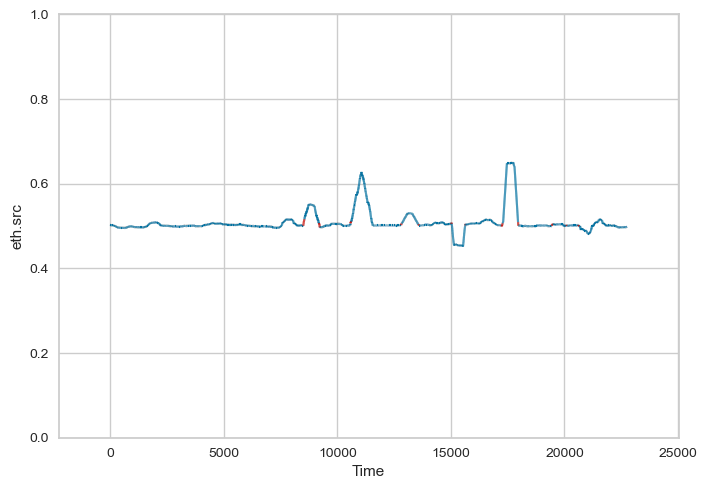

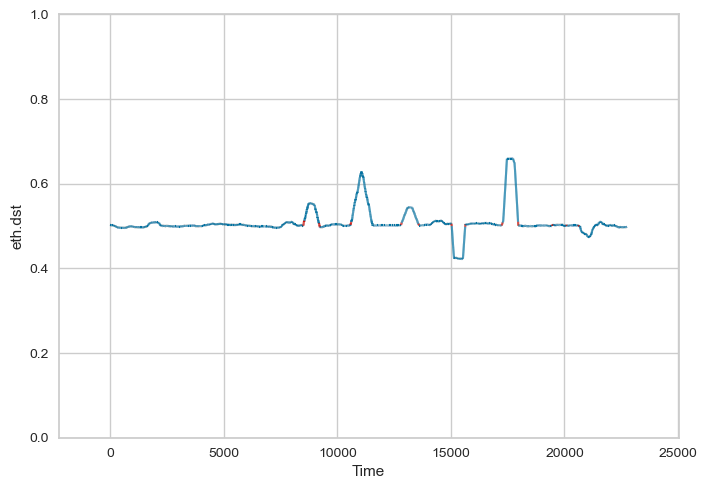

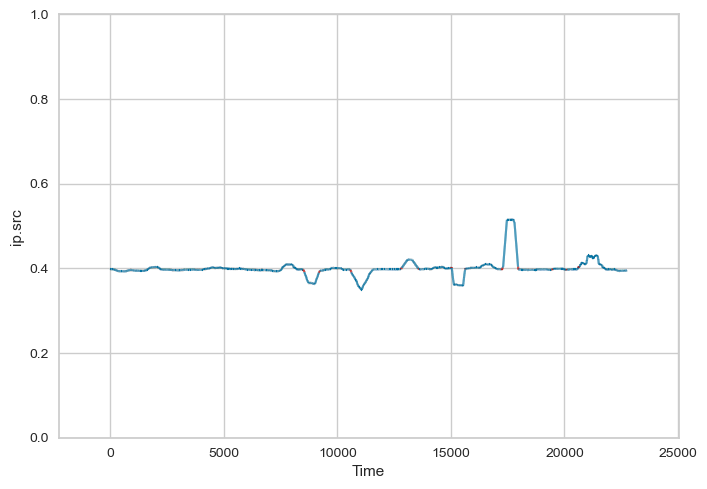

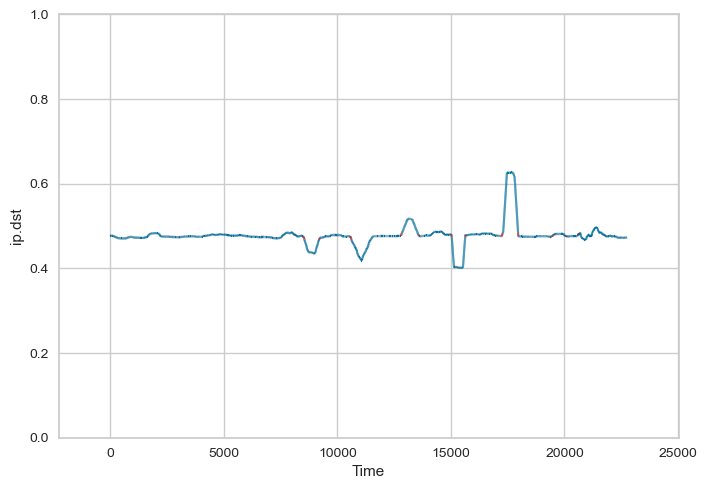

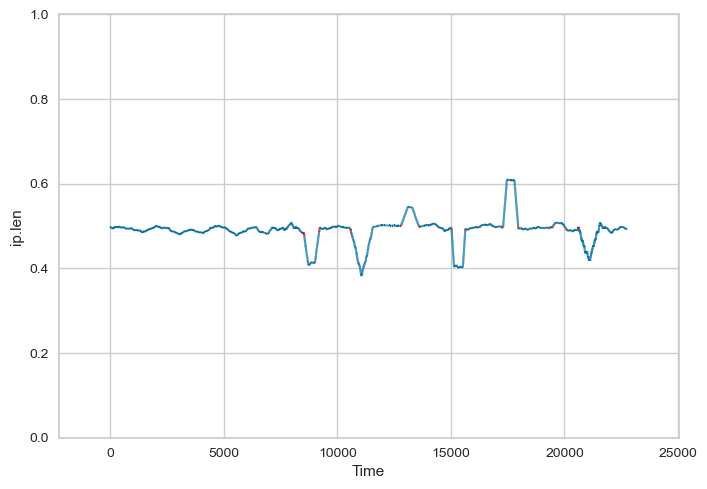

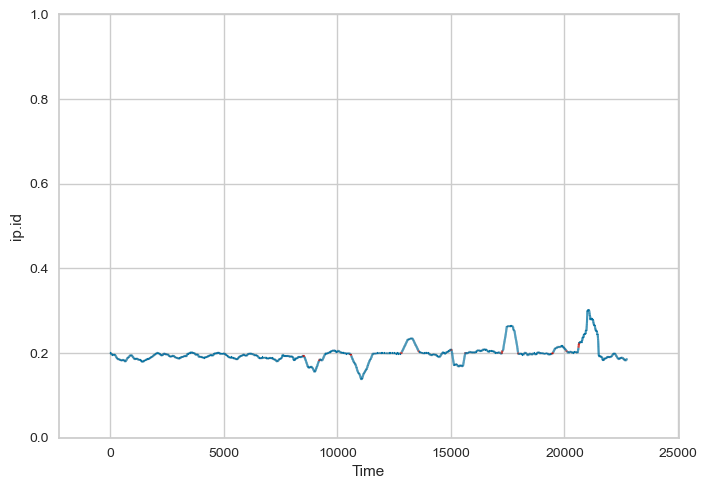

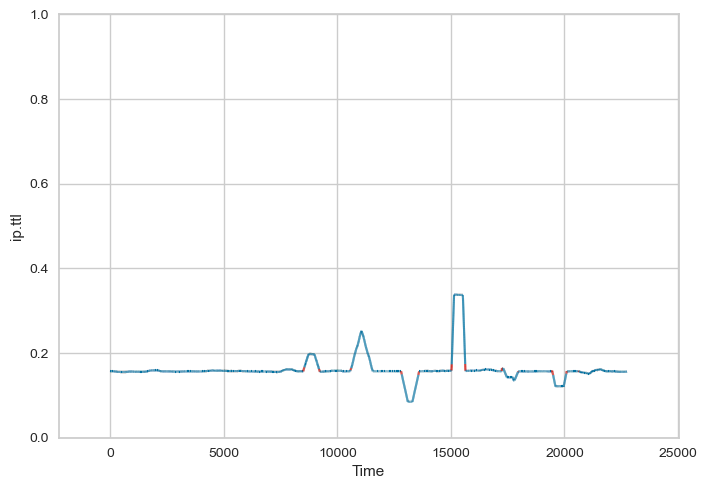

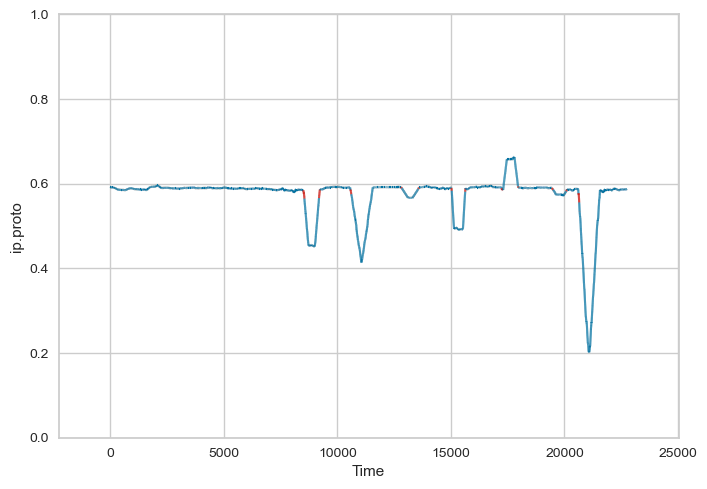

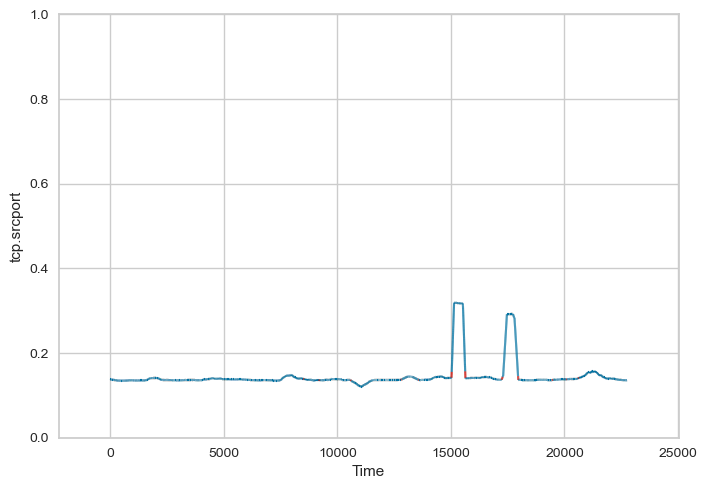

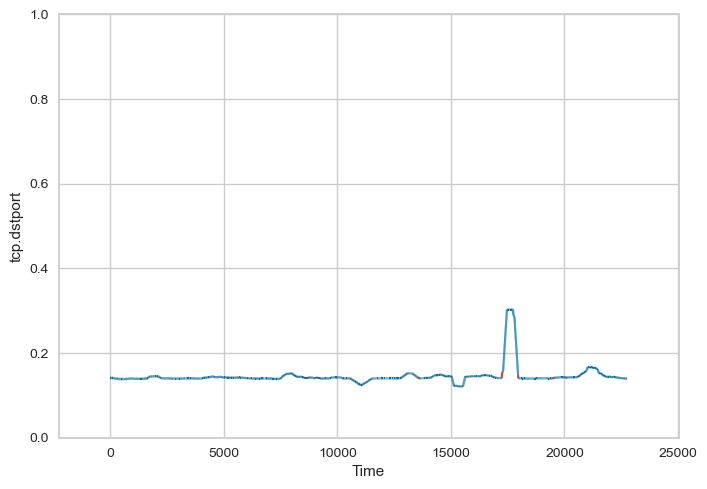

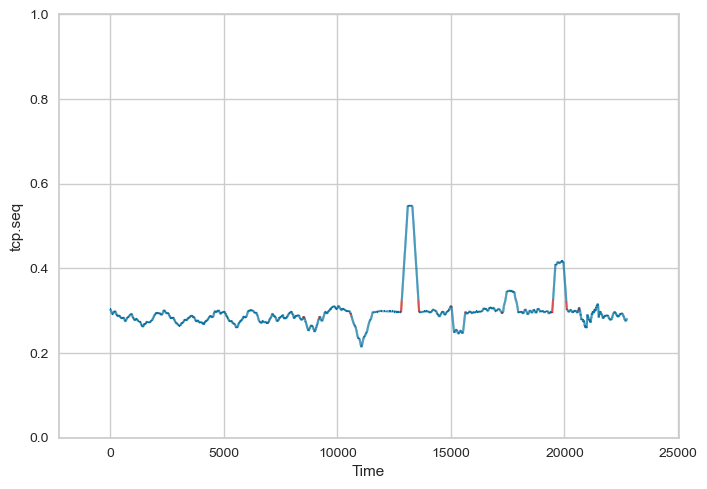

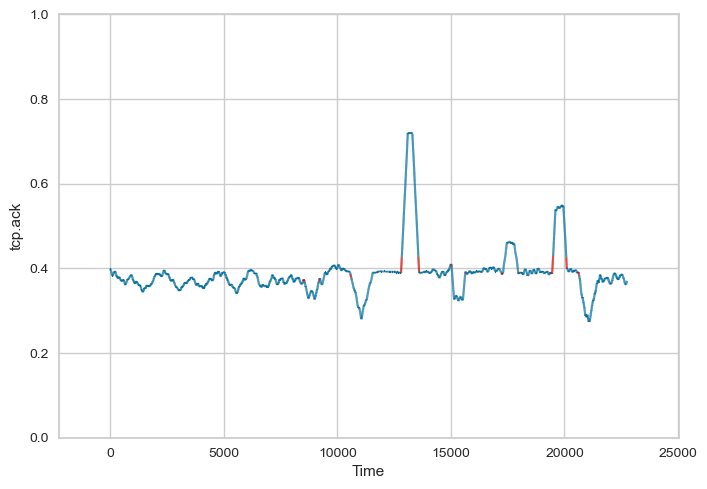

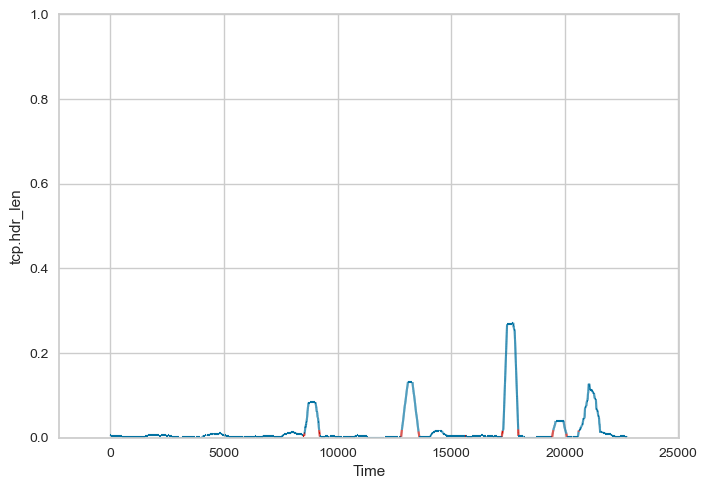

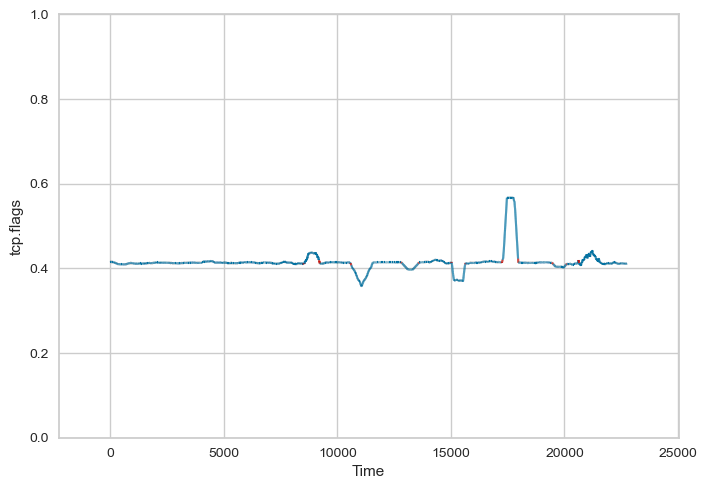

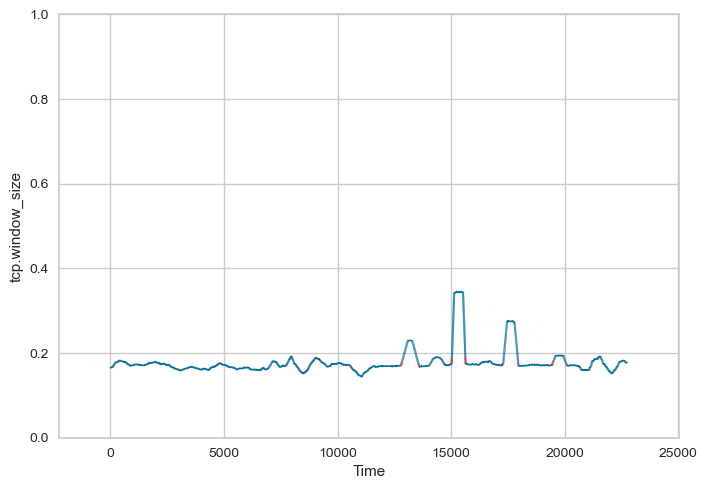

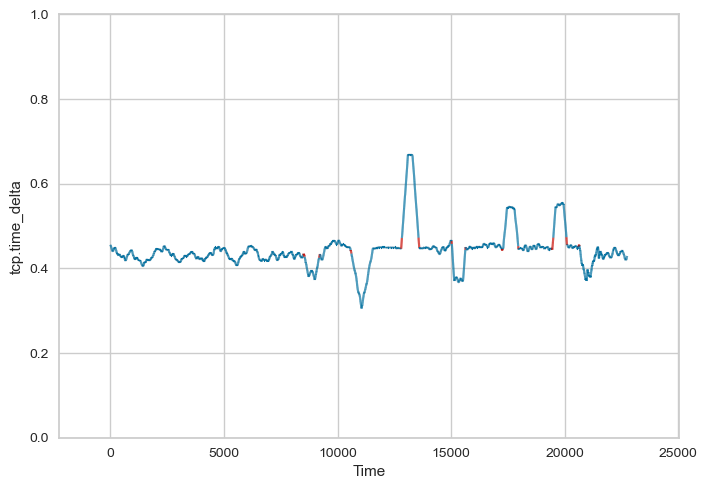

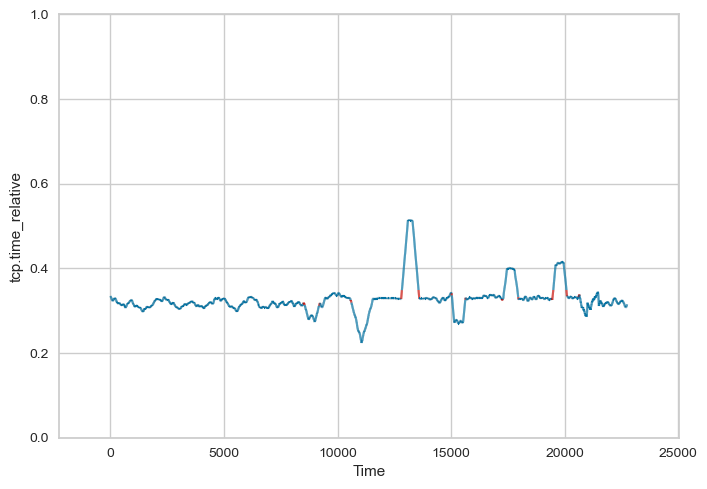

In [19]:
for i in range(1,len(col)-1):
    x = range(smooth_ics.shape[0])
    y = smooth_ics[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,fn_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

#     ax.autoscale()
    ax.margins(0.1)
    plt.ylim(0, 1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

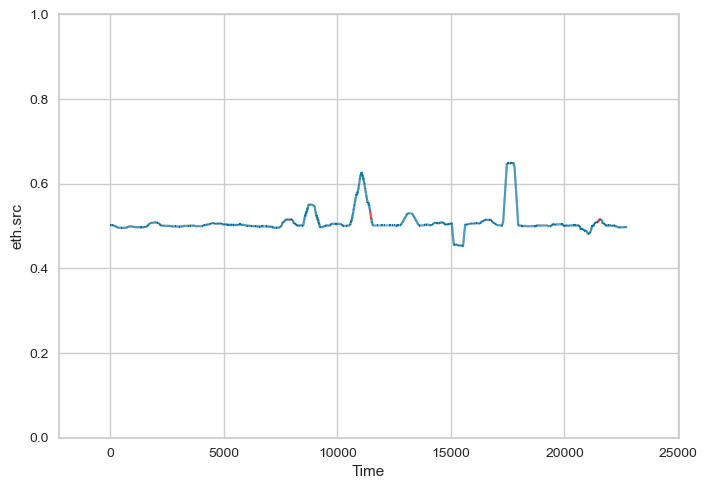

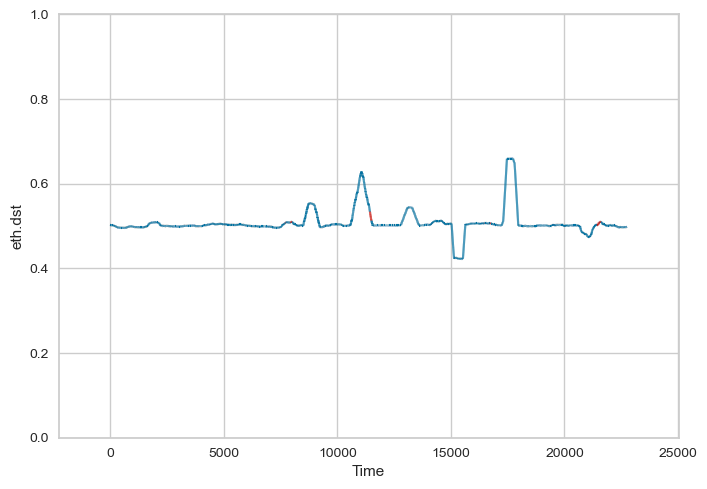

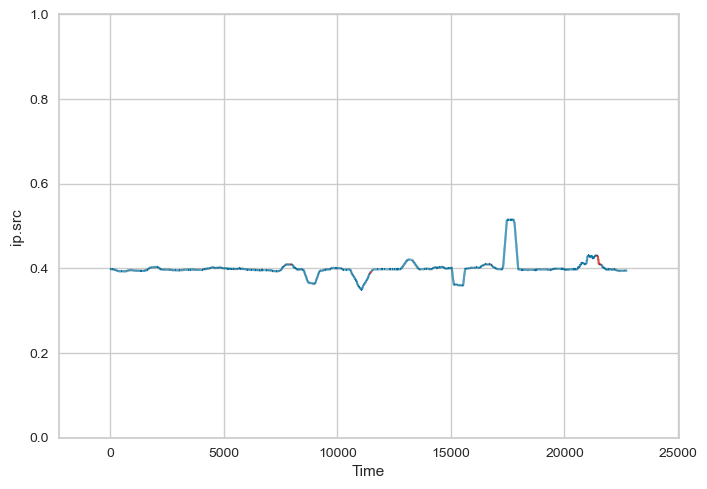

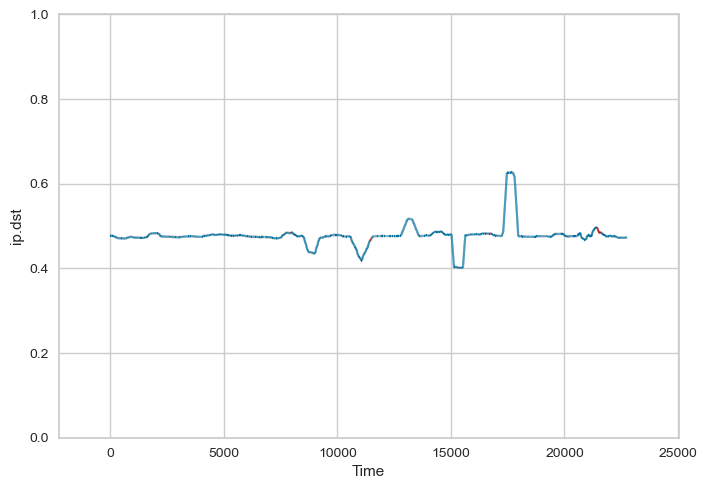

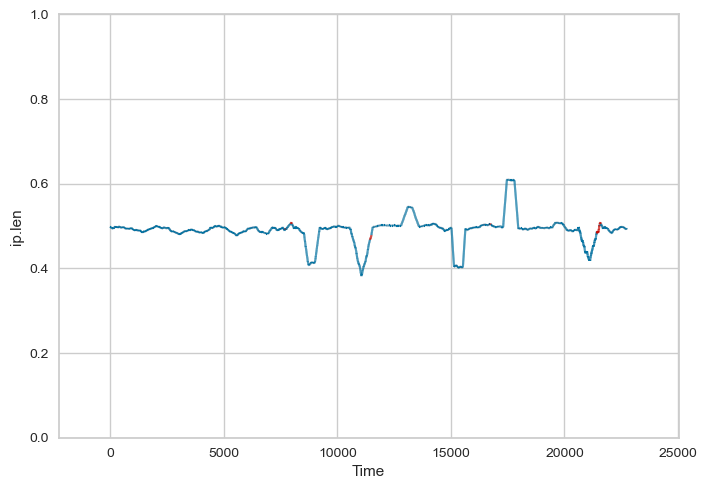

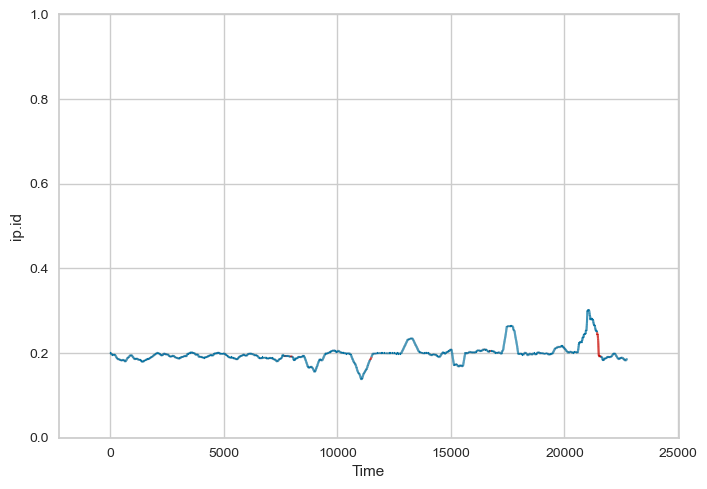

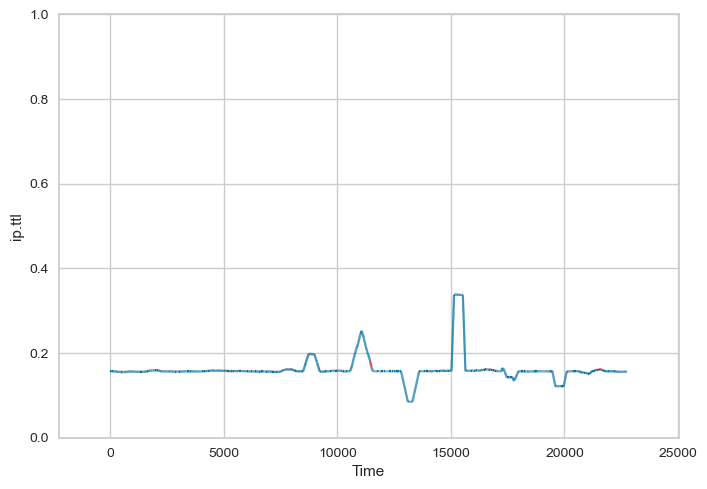

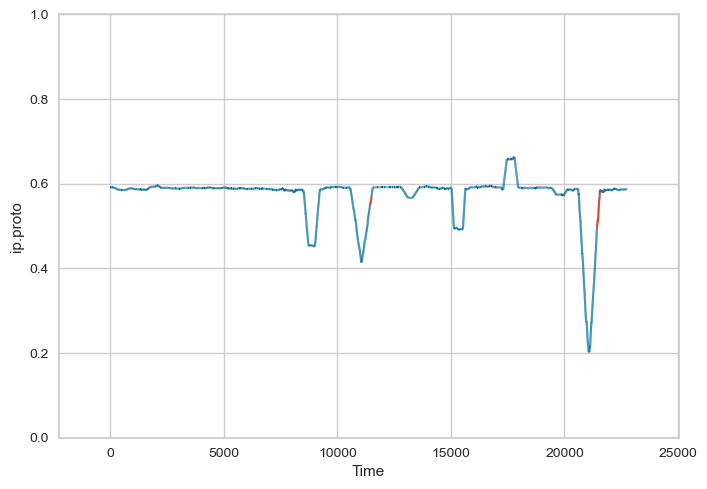

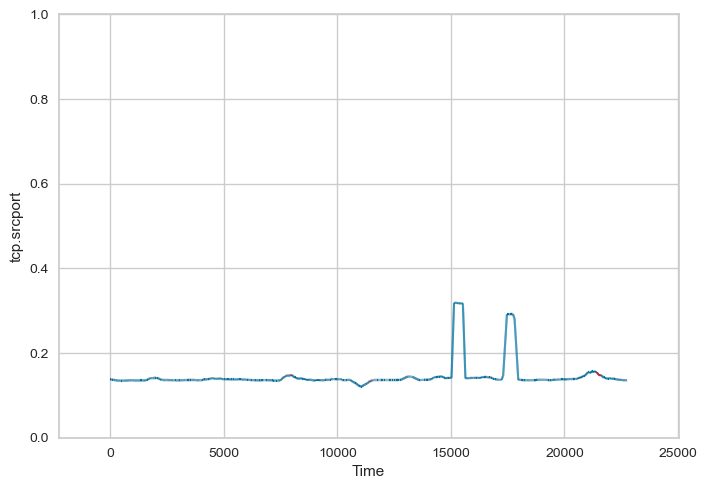

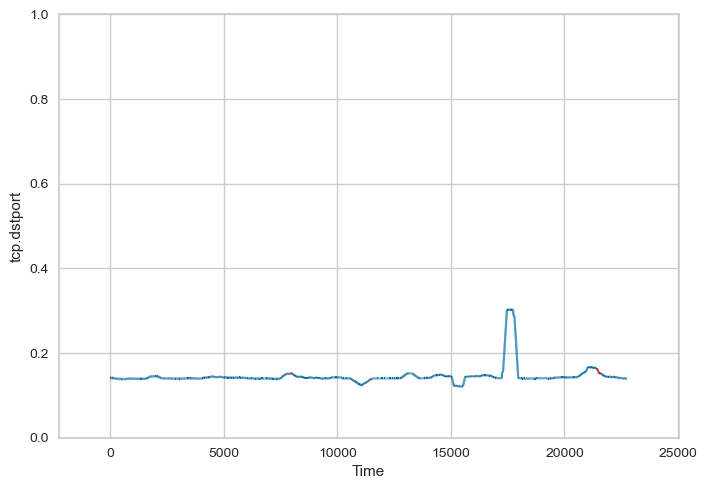

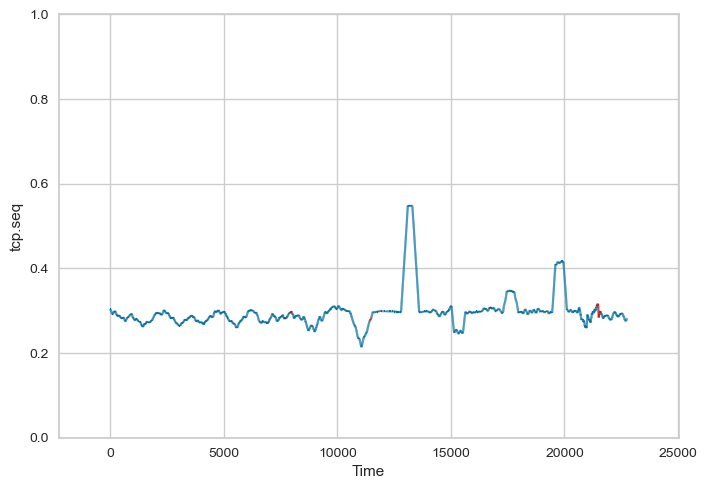

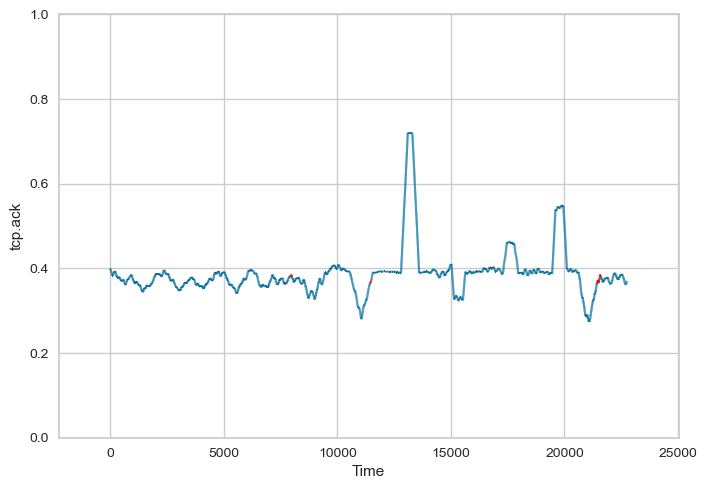

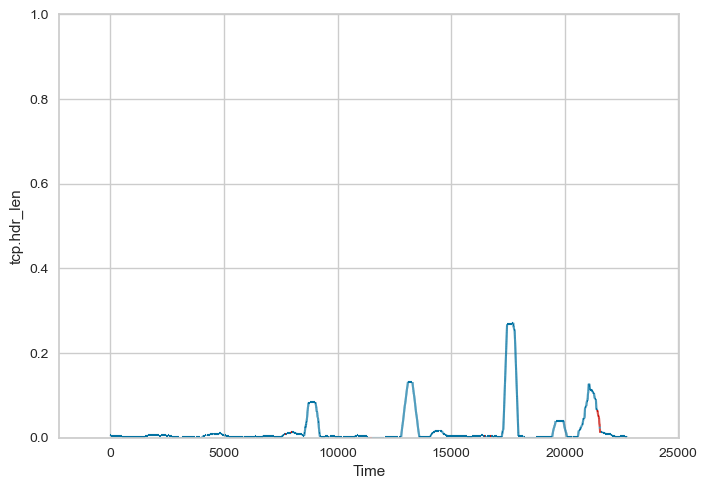

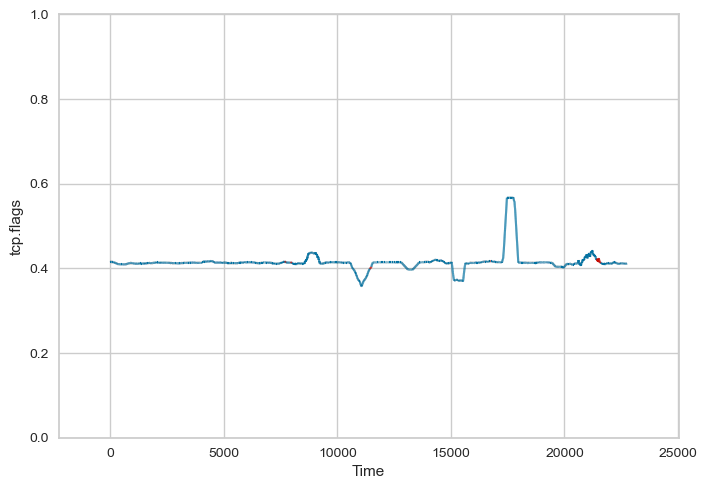

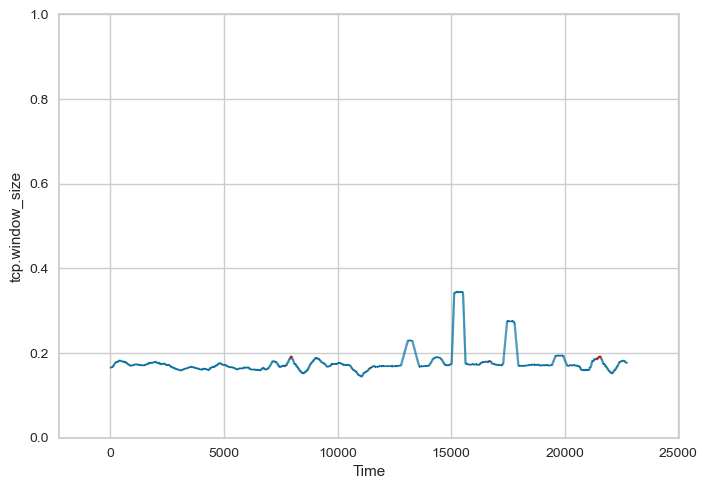

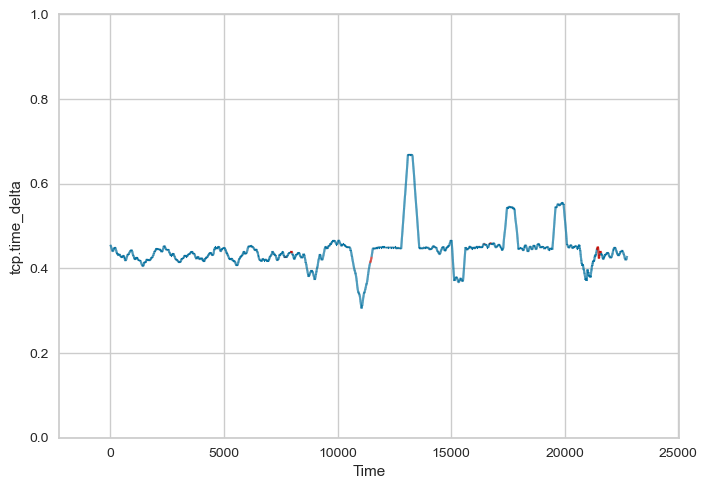

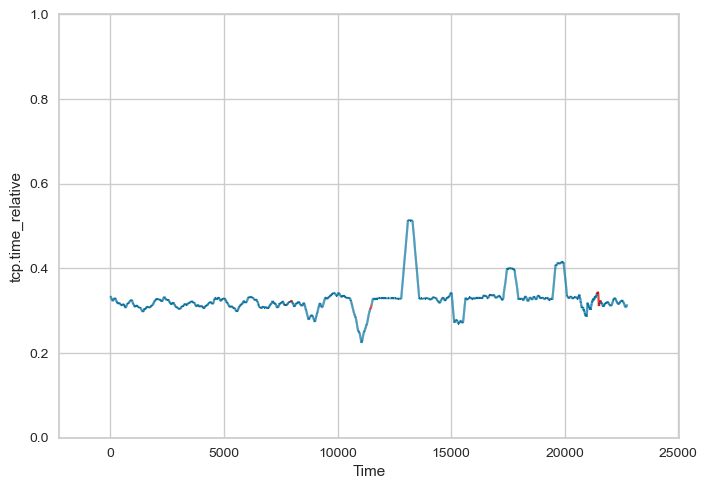

In [20]:
for i in range(1,len(col)-1):
    x = range(smooth_ics.shape[0])
    y = smooth_ics[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,fp_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

#     ax.autoscale()
    ax.margins(0.1)
    plt.ylim(0, 1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [14]:
rf = create_model('rf')
plot_model(rf, plot = 'auc')

ValueError: Estimator rf not available. Please see docstring for list of available estimators.

In [ ]:
plot_model(rf, plot = 'feature')

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

In [ ]:
plot_model(rf, plot = 'boundary', use_train_data = True)